# Design Philosophy

This notebook captures the design philosophy of the Continuous Attractor Neural Networks (CANNs) Python library so newcomers can understand each module quickly.

The library centres on CANNs and offers a unified high-level API for loading, analysing, and training state-of-the-art architectures, enabling researchers and developers to iterate on brain-inspired workflows efficiently.


## Module Overview
- `model`
  Built-in model package.
  - `basic`
    Core CANN models and their variants.
  - `brain_inspired`
    Brain-inspired models.
  - `hybrid`
    Hybrid models mixing CANNs with ANNs or other mechanisms.
- `task`
  Task utilities for CANNs, covering generation, persistence, import, and visualisation.
- `analyzer`
  Analysis helpers focused on visualisation.
  - `model analyzer`
    Tools for examining CANN models, including energy landscapes, firing rates, and tuning curves.
  - `data analyzer`
    Routines for experimental-data-driven CANN analysis or dynamical inspection of virtual RNN models.
- `trainer`
  Unified training and prediction interfaces.
- `pipeline`
  End-to-end flows that combine the above packages for streamlined execution.


## Module Walkthrough


### `models`

#### Overview
The models package implements base CANNs across different dimensionalities, brain-inspired variants, and hybrid combinations. It underpins the rest of the library and inter-operates with other modules to support varied scenarios.

The implementations are grouped by type:

- Basic Models (`canns.models.basic`)
  Canonical CANN architectures and their variants.
- Brain-Inspired Models (`canns.models.brain_inspired`)
  Brain-inspired network implementations.
- Hybrid Models (`canns.models.hybird`)
  Hybrids that couple CANNs with ANNs or other mechanisms.

These models rely on the [Brain Simulation Ecosystem](https://brainmodeling.readthedocs.io/index.html), especially [brainstate](https://brainstate.readthedocs.io). `brainstate`—backed by JAX/BrainUnit—provides the `brainstate.nn.Dynamics` abstraction, `State`/`HiddenState`/`ParamState` containers, unified time-step control via `brainstate.environ`, and utilities such as `brainstate.compile.for_loop` and `brainstate.random`. With these building blocks, CANN implementations only describe variables and update rules while brainstate handles time stepping, parallelism, and randomness, lowering implementation overhead.


#### Usage Examples
The following examples summarise the end-to-end workflow, see `examples/cann/cann1d_oscillatory_tracking.py`, `examples/cann/cann2d_tracking.py`, and `examples/brain_inspired/hopfield_train.py`.


In [1]:
import brainstate as bst
from canns.models.basic import CANN1D, CANN2D
from canns.task.tracking import SmoothTracking1D, SmoothTracking2D
from canns.analyzer.plotting import (
    PlotConfigs,
    energy_landscape_1d_animation,
    energy_landscape_2d_animation,
)

bst.environ.set(dt=0.1)

# Create a 1D CANN instance and initialise its state
cann = CANN1D(num=512)  # 512 neurons
cann.init_state()       # Initialise the neural network state

# Use a SmoothTracking1D task (described later) to generate stimuli
task_1d = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),
    duration=(10.0,) * 4,
    time_step=bst.environ.get_dt(),
)
task_1d.get_data()  # Generate task data

# Define a step function that applies the stimulus to the CANN
def step_1d(_, stimulus):
    cann(stimulus)                          # Update the CANN state with the provided stimulus
    return cann.u.value, cann.inp.value     # Return membrane potential and external input

us, inputs = bst.compile.for_loop(step_1d, task_1d.run_steps, task_1d.data) # Run the step function via brainstate.compile.for_loop

<SmoothTracking1D> Generating Task data: 400it [00:00, 2409.20it/s]


For brain-inspired models, refer to the Hopfield example (`examples/brain_inspired/hopfield_train.py`) to perform pattern recovery from noisy images.


In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# Instantiate the Amari Hopfield network and initialise its state
model = AmariHopfieldNetwork(num_neurons=128 * 128, asyn=False, activation='sign')
model.init_state()  # Initialise the neural network state

trainer = HebbianTrainer(model) # Create the HebbianTrainer (explained later in this notebook)
trainer.train(train_patterns)  # `train_patterns`: List[np.ndarray] of shape (N,) used for training
denoised = trainer.predict_batch(noisy_patterns, show_sample_progress=True)

#### Extension Guidelines
Because the core implementations depend on `brainstate`, consult the official documentation (https://brainstate.readthedocs.io) when extending models. Key topics include registering states with `nn.Dynamics`, managing time via `environ.set/get_dt`, batching updates with `compile.for_loop`, and working with `ParamState`/`HiddenState`. Mastering these concepts helps produce numerics and APIs that interoperate with existing components.

##### For basic models

Each model inherits from `canns.models.basic.BasicModel` or `BasicModelGroup`. Typical tasks include:

- Call the parent constructor in `__init__` (e.g. `super().__init__(math.prod(shape), **kwargs)`) and store `shape`, `varshape`, or related dimensions.
- Implement `make_conn()` to build the connectivity matrix and assign it to `self.conn_mat` (see the Gaussian kernel implementation in `src/canns/models/basic/cann.py`).
- Implement `get_stimulus_by_pos(pos)` so tasks can request external stimuli from feature-space positions.
- Register `brainstate.HiddenState`/`State` objects in `init_state()` (commonly `self.u`, `self.r`, `self.inp`) to ensure updates can read and write directly.
- Write the single-step dynamics inside `update(inputs)` and scale by `brainstate.environ.get_dt()` for numerical stability.
- Expose diagnostic values or axes (such as `self.x` or `self.rho`) through properties for reuse by tasks, analyzers, and pipelines.

##### For brain-inspired models

Models inherit from `canns.models.brain_inspired.BrainInspiredModel` or `BrainInspiredModelGroup`. To extend them:

- Register the state vector (default `self.s`) and weight matrix `self.W` inside `init_state()`; store weights in a `brainstate.ParamState` so Hebbian learning can write back directly.
- Override `weight_attr` if the weight field is not called `W`, allowing `HebbianTrainer` to locate it.
- Implement `update(...)` and the `energy` property so the trainer can run the generic prediction loop and detect convergence.
- Implement `apply_hebbian_learning(patterns)` when customised Hebbian rules are required; otherwise rely on the trainer’s generic update.
- Override `resize(num_neurons, preserve_submatrix=True)` if the model supports dynamic resizing (see `src/canns/models/brain_inspired/hopfield.py`).

##### For hybrid models

Future work (待补充 / TBD).


### `task`

#### Overview
The task package generates, saves, loads, imports, and visualises CANN-specific stimuli. It offers predefined task types while allowing custom extensions for specialised needs.


#### Usage Examples
For a one-dimensional tracking task (see `examples/cann/cann1d_oscillatory_tracking.py`):


In [20]:
from canns.task.tracking import SmoothTracking1D
from canns.models.basic import CANN1D
from canns.analyzer.plotting import energy_landscape_1d_animation, PlotConfigs

# Create a SmoothTracking1D task
task_st = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1., 0.75, 2., 1.75, 3.),   # External input amplitudes for each phase of the SmoothTracking1D task
    duration=(10., 10., 10., 10.),   # Duration of each phase (four phases of 10 time units)
    time_step=bst.environ.get_dt(),
)
task_st.get_data()  # Generate task data

task_st.data  # Task data containing the time series and corresponding stimuli

<SmoothTracking1D> Generating Task data: 400it [00:00, 9206.62it/s]


array([[0.10189284, 0.09665093, 0.09165075, ..., 0.11314222, 0.10738649,
        0.10189275],
       [0.10079604, 0.09560461, 0.09065294, ..., 0.11193825, 0.10623717,
        0.10079593],
       [0.09970973, 0.0945684 , 0.08966482, ..., 0.11074577, 0.10509886,
        0.09970973],
       ...,
       [9.72546482, 9.68417931, 9.64015198, ..., 9.79967213, 9.76397419,
        9.72546482],
       [9.76497078, 9.72653675, 9.68532467, ..., 9.83337116, 9.80059338,
        9.76497078],
       [9.80151176, 9.76596642, 9.72760582, ..., 9.86403942, 9.8342123 ,
        9.80151081]], shape=(400, 512))

`SmoothTracking1D` and `SmoothTracking2D` automatically interpolate smooth trajectories from key points. `task.data` and `task.Iext_sequence` can be consumed directly by models or analyzers.

Every task inherits the base `save_data`/`load_data` helpers for repeatable experiments:


In [21]:
task.save_data("outputs/tracking_task.npz")
# ... later or on another machine
restored = SmoothTracking1D(
    cann_instance=cann_model,
    Iext=(1.0, 0.8, 2.2, 1.5),
    duration=(8.0,) * 3,
    time_step=bst.environ.get_dt(),
)
restored.load_data("outputs/tracking_task.npz")

Data successfully saved to: outputs/tracking_task.npz
Data successfully loaded from: outputs/tracking_task.npz


When `self.data` is a dataclass (for example `SpatialNavigationData`), the base class serialises individual fields and reconstructs the structured object on load.

`SpatialNavigationTask` can synthesise trajectories or import recordings. See `examples/cann/theta_sweep_grid_cell_network.py` for the analysis flow and `examples/cann/import_external_trajectory.py` for trajectory import.


Successfully imported trajectory data with 800 time steps
Spatial dimensions: 2D
Time range: 0.000 to 1.598 s
Mean speed: 1.395 units/s
Trajectory analysis saved to: trajectory.png


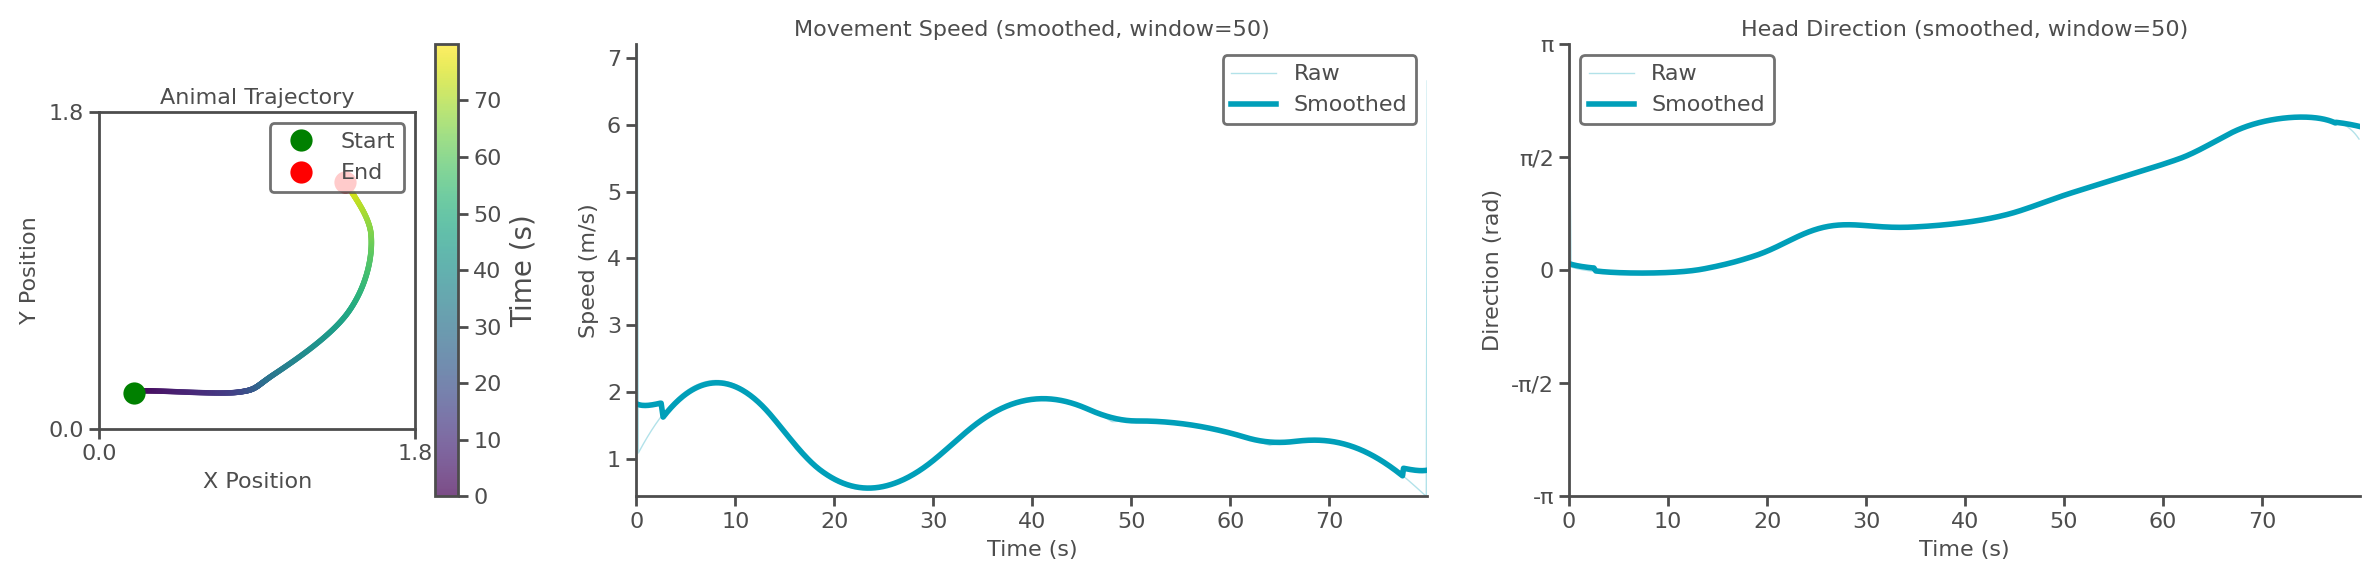

In [3]:
import numpy as np
import os
from canns.task.spatial_navigation import SpatialNavigationTask

# Load external position data with NumPy
data = np.load(os.path.join(os.getcwd(), "..", "..", "en", "notebooks", "external_trajectory.npz"))
positions = data["positions"]  # Shape: (time_steps, 2)
times = data["times"]          # Shape: (time_steps,)
simulate_time = times[-1] - times[0]
env_size = 1.8
dt = 0.1

task = SpatialNavigationTask(duration=simulate_time, width=env_size, height=env_size, dt=dt)
task.import_data(position_data=positions, times=times)  # Import the external position data
task.calculate_theta_sweep_data()   # Compute theta-sweep features
task.show_trajectory_analysis(save_path="trajectory.png", show=True, smooth_window=50) # Visualise the trajectory analysis

#### Extension Guidelines

To build a custom task, inherit `canns.task.Task` and follow these steps:

- Parse configuration in the constructor and optionally set `data_class`.
- Implement `get_data()` to generate or load data, storing the output in `self.data` (either a `numpy.ndarray` or a dataclass).
- Provide import helpers such as `import_data(...)` when external data must match the `self.data` structure.
- Implement `show_data(show=True, save_path=None)` for the most relevant visualisation.
- Reuse the base `save_data`/`load_data` for persistence instead of re-implementing them.


### `analyzer`

#### Overview
The analyzer package supplies tools for inspecting CANN models and experimental datasets. It spans two categories: model analysis and data analysis.


#### Usage

##### Model analysis

After combining a model with a task, invoke analyzer helpers to produce visualisations. Continuing the 1D tracking workflow:


In [ ]:
import brainstate
from canns.task.tracking import SmoothTracking1D
from canns.models.basic import CANN1D
from canns.analyzer.plotting import energy_landscape_1d_animation, PlotConfigs

brainstate.environ.set(dt=0.1)



# Create a SmoothTracking1D task
task_st = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1., 0.75, 2., 1.75, 3.),   # External input amplitudes for each phase of the SmoothTracking1D task
    duration=(10., 10., 10., 10.),   # Duration of each phase (four phases of 10 time units)
    time_step=brainstate.environ.get_dt(),
)
task_st.get_data()  # Generate task data


# Define a step function that drives the CANN with the generated inputs
def run_step(t, inputs):
    cann(inputs)
    return cann.u.value, cann.inp.value

# Execute the loop with brainstate.compile.for_loop
us, inps = brainstate.compile.for_loop(
    run_step,
    task_st.run_steps,  # Total number of simulation steps
    task_st.data,       # Task data produced by SmoothTracking1D
    pbar=brainstate.compile.ProgressBar(10) # Update the progress bar every 10 iterations
)

# Configure and generate the energy landscape animation
config = PlotConfigs.energy_landscape_1d_animation(
    time_steps_per_second=100,
    fps=20,
    title='Smooth Tracking 1D',
    xlabel='State',
    ylabel='Activity',
    repeat=True,
    save_path='smooth_tracking_1d.gif',
    show=False
)

# Render the energy landscape animation
energy_landscape_1d_animation(
    data_sets={'u': (cann.x, us), 'Iext': (cann.x, inps)},
    config=config
)

![smooth_tracking_1d](../../_static/smooth_tracking_1d.gif)

For two-dimensional activity, call `energy_landscape_2d_animation(zs_data=...)` to render the heat map.


![smooth_tracking_1d](../../_static/CANN2D_encoding.gif)

##### Data analysis

Follow the repository scripts for end-to-end workflows:

- `examples/experimental_cann1d_analysis.py`: `load_roi_data()` loads sample ROI traces, then `bump_fits` and `create_1d_bump_animation` fit and animate 1D bumps.
- `examples/experimental_cann2d_analysis.py`: after `embed_spike_trains`, use UMAP and `plot_projection` for dimensionality reduction, then call `tda_vis`, `decode_circular_coordinates`, and `plot_3d_bump_on_torus` for topological analysis and torus animation.


![bump_analysis](../../_static/bump_analysis_demo.gif)

![torus_bump](../../_static/torus_bump.gif)

#### Extension Guidelines

##### Model analysis

Although analyzers share no base class, follow the preset pattern in `src/canns/analyzer/plotting/config.py`: parameterise titles, axes, frame rates, and other options through `PlotConfig`/`PlotConfigs`, and accept a `config` object in plotting functions. This keeps visual interfaces consistent and easy to customise.

##### Data analysis

Likewise, data-analysis helpers have no common base. Implement custom utilities as required for specific datasets.


### `trainer`

#### Overview
The trainer package exposes unified interfaces for training and evaluating brain-inspired models. It currently focuses on Hebbian learning, with room to add additional strategies later.


#### Usage

Refer to `examples/brain_inspired/hopfield_train.py` for `HebbianTrainer` in practice:


Processing samples: 100%|█████████████| 4/4 [00:04<00:00,  1.05s/it, sample=4/4]


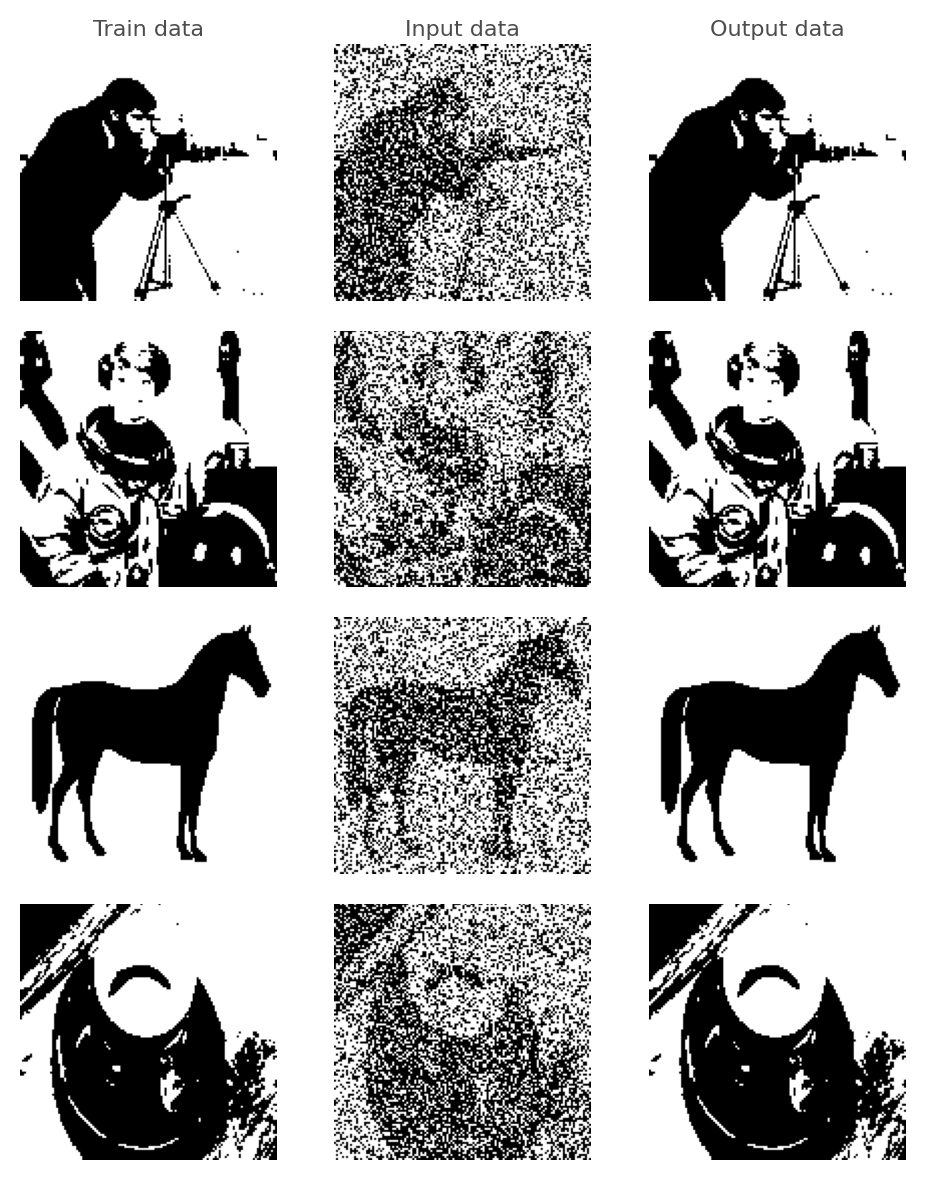

In [28]:
import numpy as np
import skimage.data
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize

from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

np.random.seed(42)

def preprocess_image(img, w=128, h=128) -> np.ndarray:
    """Resize, grayscale (if needed), threshold to binary, then map to {-1,+1}."""
    if img.ndim == 3:
        img = rgb2gray(img)
    img = resize(img, (w, h), anti_aliasing=True)
    img = img.astype(np.float32, copy=False)
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = np.where(binary, 1.0, -1.0).astype(np.float32)
    return shift.reshape(w * h)

# Load training images from skimage
camera = preprocess_image(skimage.data.camera())
astronaut = preprocess_image(skimage.data.astronaut())
horse = preprocess_image(skimage.data.horse().astype(np.float32))
coffee = preprocess_image(skimage.data.coffee())

data_list = [camera, astronaut, horse, coffee]

# Instantiate the Amari Hopfield network and initialise its state
model = AmariHopfieldNetwork(num_neurons=data_list[0].shape[0], asyn=False, activation="sign")
model.init_state()

# Create the HebbianTrainer and train the network
trainer = HebbianTrainer(model)
trainer.train(data_list)

# Create noisy test patterns
def get_corrupted_input(input, corruption_level):
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

tests = [get_corrupted_input(d, 0.3) for d in data_list]

# Predict the denoised patterns
predicted = trainer.predict_batch(tests, show_sample_progress=True)

# Visualise the predictions
def plot(data, test, predicted, figsize=(5, 6)):
    def reshape(data):
        dim = int(np.sqrt(len(data)))
        data = np.reshape(data, (dim, dim))
        return data

    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]

    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title('Output data')

        axarr[i, 0].imshow(data[i], cmap='gray')
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i], cmap='gray')
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i], cmap='gray')
        axarr[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig("discrete_hopfield_train.png")
    plt.show()


plot(data_list, tests, predicted, figsize=(5, 6))

#### Extension Guidelines

To introduce a new trainer, inherit `canns.trainer.Trainer` and:

- Capture the target model and progress settings in the constructor.
- Implement `train(self, train_data)` to define the parameter update rule.
- Implement `predict(self, pattern, *args, **kwargs)` for single-sample inference, using `predict_batch` for batching when appropriate.
- Honour the default `configure_progress` contract so users can toggle iteration progress or compilation.
- Agree on shared attribute names (for example weights or state vectors) when the trainer cooperates with specific models.


### Pipeline

#### Overview
The pipeline package chains models, tasks, analyzers, and trainers into end-to-end workflows so that common needs are satisfied with minimal user code.


#### Usage

Run `ThetaSweepPipeline` for a full workflow (see `examples/pipeline/theta_sweep_from_external_data.py`):


🚀 Starting Theta Sweep Pipeline...
📊 Setting up spatial navigation task...
Successfully imported trajectory data with 800 time steps
Spatial dimensions: 2D
Time range: 0.000 to 1.598 s
Mean speed: 1.395 units/s
🧠 Setting up neural networks...
⚡ Running theta sweep simulation...


/Users/sichaohe/Documents/GitHub/canns/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Running for 800 iterations: 100%|██████████| 800/800 [00:10<00:00, 75.01it/s]


📈 Generating trajectory analysis...
Trajectory analysis saved to: theta_sweep_results/trajectory_analysis.png
📊 Generating population activity plot...
Plot saved to: theta_sweep_results/population_activity.png
🎬 Creating theta sweep animation...
[theta_sweep] Using imageio backend for theta sweep animation (auto-detected).
[theta_sweep] Detected JAX; using 'spawn' start method to avoid fork-related deadlocks.


<theta_sweep> Rendering frames: 100%|██████████| 80/80 [03:42<00:00,  2.78s/it]


✅ Pipeline completed successfully!
📁 Results saved to: /Users/sichaohe/Documents/GitHub/canns/docs/zh/notebooks/theta_sweep_results


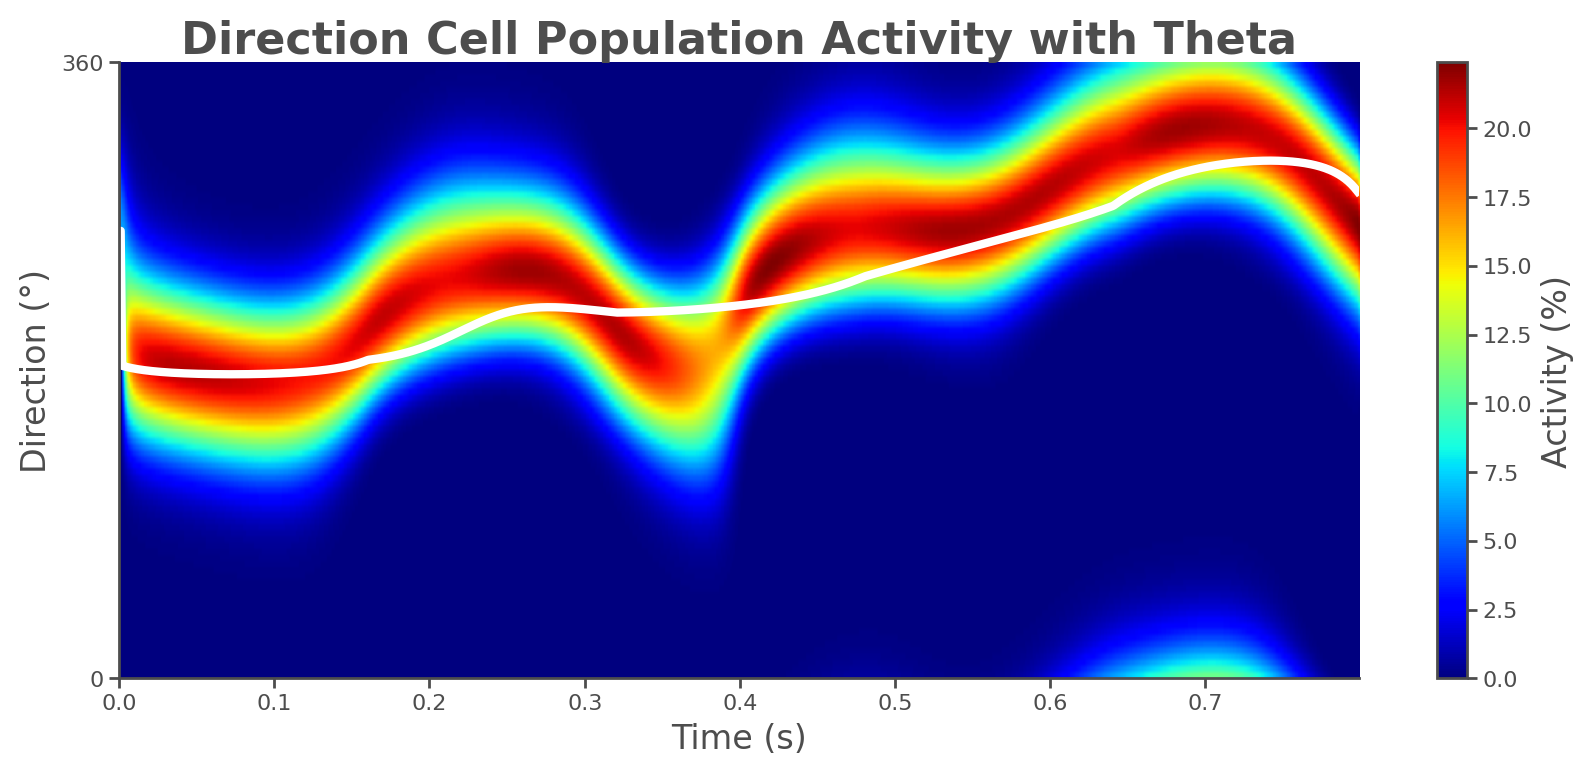

In [4]:
from canns.pipeline import ThetaSweepPipeline

pipeline = ThetaSweepPipeline(
    trajectory_data=positions,
    times=times,
    env_size=env_size,
)
results = pipeline.run(output_dir="theta_sweep_results")

![bump_analysis](../../_static/theta_sweep_animation.gif)

The returned `results` dictionary contains the animation, trajectory analysis, and raw simulation data, which can feed follow-up analyses.


#### Extension Guidelines

To customise a pipeline:

- Inherit `canns.pipeline.Pipeline` and implement `run(...)`, returning a dictionary of primary artefacts.
- Call `prepare_output_dir()` as needed and cache outputs with `set_results()` for later use via `get_results()`.
- Orchestrate models, tasks, and analyzers inside `run()` while keeping input and output formats explicit.
- Invoke `reset()` before repeated executions to clear cached state.
